In [1]:
!nvidia-smi

Thu Feb 29 23:25:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   38C    P8              21W / 215W |    509MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
data_dir = '../data/data_preprocessed/esd/features_4balanced/'

sr = 16000

data_x = np.load(f'{data_dir}esd.audio16k.npy', 
                 allow_pickle=True)
data_y = np.load(f'{data_dir}esd.label_emotion.npy', 
                 allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 22400
Test: 5600


In [8]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [11]:
labels = ['ang', 'neu', 'sad', 'hap']
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [10]:
import traceback
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13mfcc128.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 128, 'n_fft': 1024, 'hop_length': 128, 'n_mels': 128, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [12]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [13]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [14]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                               | 0.001142857142857143/10 [00:00<1:11:51, 431.16s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.741649
Mem before-during-after: 1660928 10332672 22687232


  0%|                                 | 0.023999999999999983/10 [00:07<48:50, 293.75s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.412265
Mem before-during-after: 22687232 22838272 22687232


  0%|▏                                | 0.046857142857142785/10 [00:13<45:21, 273.48s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.214767
Mem before-during-after: 22687232 22838272 22687232


  1%|▏                                 | 0.06971428571428559/10 [00:19<46:34, 281.38s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 0.995145
Mem before-during-after: 22687232 22838272 22687232


  1%|▎                                 | 0.09257142857142839/10 [00:25<45:28, 275.42s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.262530
Mem before-during-after: 22687232 22838272 22687232


  1%|▍                                 | 0.11542857142857119/10 [00:32<44:52, 272.38s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 0.963087
Mem before-during-after: 22687232 22838272 22687232


  1%|▍                                 | 0.13828571428571432/10 [00:38<45:40, 277.85s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.131410
Mem before-during-after: 22687232 22838272 22687232


  2%|▌                                 | 0.16114285714285767/10 [00:44<44:12, 269.57s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 0.861433
Mem before-during-after: 22687232 22838272 22687232


  2%|▋                                 | 0.18400000000000102/10 [00:51<47:01, 287.43s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 1.055699
Mem before-during-after: 22687232 22838272 22687232


  2%|▋                                 | 0.20685714285714438/10 [00:57<46:56, 287.64s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 0.963959
Mem before-during-after: 22687232 22838272 22687232


  2%|▊                                 | 0.22971428571428773/10 [01:03<42:11, 259.07s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 0.983898
Mem before-during-after: 22687232 22838272 22687232


  3%|▊                                 | 0.25257142857143094/10 [01:10<44:01, 271.02s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 1.191399
Mem before-during-after: 22687232 22838272 22687232


  3%|▉                                  | 0.2754285714285732/10 [01:16<45:26, 280.39s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 1.042503
Mem before-during-after: 22687232 22838272 22687232


  3%|█                                 | 0.29828571428571543/10 [01:22<44:12, 273.38s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 1.260522
Mem before-during-after: 22687232 22838272 22687232


  3%|█                                  | 0.3211428571428577/10 [01:29<46:31, 288.41s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: 0.788855
Mem before-during-after: 22687232 22838272 22687232


  3%|█▏                                 | 0.3439999999999999/10 [01:35<44:06, 274.13s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: 1.052420
Mem before-during-after: 22687232 22838272 22687232


  4%|█▏                                | 0.36685714285714216/10 [01:42<47:19, 294.78s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: 0.749025
Mem before-during-after: 22687232 22838272 22687232


  4%|█▎                                 | 0.3897142857142844/10 [01:48<44:54, 280.33s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: 0.662832
Mem before-during-after: 22687232 22838272 22687232


  4%|█▍                                | 0.41257142857142665/10 [01:54<42:53, 268.38s/it]

Train Epoch: 1 [11520/22400 (51%)]	Loss: 0.685314
Mem before-during-after: 22687232 22838272 22687232


  4%|█▌                                 | 0.4354285714285689/10 [02:01<43:35, 273.50s/it]

Train Epoch: 1 [12160/22400 (54%)]	Loss: 1.271330
Mem before-during-after: 22687232 22838272 22687232


  5%|█▌                                | 0.45828571428571113/10 [02:07<45:22, 285.30s/it]

Train Epoch: 1 [12800/22400 (57%)]	Loss: 0.838813
Mem before-during-after: 22687232 22838272 22687232


  5%|█▋                                 | 0.4811428571428534/10 [02:13<42:52, 270.26s/it]

Train Epoch: 1 [13440/22400 (60%)]	Loss: 0.688421
Mem before-during-after: 22687232 22838272 22687232


  5%|█▊                                 | 0.5039999999999957/10 [02:20<43:29, 274.83s/it]

Train Epoch: 1 [14080/22400 (63%)]	Loss: 1.419376
Mem before-during-after: 22687232 22838272 22687232


  5%|█▊                                 | 0.5268571428571379/10 [02:26<43:35, 276.12s/it]

Train Epoch: 1 [14720/22400 (66%)]	Loss: 1.095944
Mem before-during-after: 22687232 22838272 22687232


  5%|█▉                                 | 0.5497142857142802/10 [02:33<43:06, 273.73s/it]

Train Epoch: 1 [15360/22400 (69%)]	Loss: 0.751008
Mem before-during-after: 22687232 22838272 22687232


  6%|█▉                               | 0.5719999999999938/10 [02:41<1:27:21, 555.92s/it]

Train Epoch: 1 [16000/22400 (71%)]	Loss: 1.051973
Mem before-during-after: 22687232 22838272 22687232


  6%|██                                 | 0.5954285714285646/10 [02:47<43:19, 276.37s/it]

Train Epoch: 1 [16640/22400 (74%)]	Loss: 0.490873
Mem before-during-after: 22687232 22838272 22687232


  6%|██▏                                | 0.6182857142857069/10 [02:54<43:10, 276.12s/it]

Train Epoch: 1 [17280/22400 (77%)]	Loss: 0.784766
Mem before-during-after: 22687232 22838272 22687232


  6%|██▏                                | 0.6411428571428491/10 [03:00<42:11, 270.44s/it]

Train Epoch: 1 [17920/22400 (80%)]	Loss: 0.568159
Mem before-during-after: 22687232 22838272 22687232


  7%|██▎                                | 0.6639999999999914/10 [03:06<43:55, 282.30s/it]

Train Epoch: 1 [18560/22400 (83%)]	Loss: 0.724451
Mem before-during-after: 22687232 22838272 22687232


  7%|██▍                                | 0.6868571428571336/10 [03:12<41:56, 270.20s/it]

Train Epoch: 1 [19200/22400 (86%)]	Loss: 0.632790
Mem before-during-after: 22687232 22838272 22687232


  7%|██▍                                | 0.7097142857142759/10 [03:19<45:38, 294.79s/it]

Train Epoch: 1 [19840/22400 (89%)]	Loss: 0.424723
Mem before-during-after: 22687232 22838272 22687232


  7%|██▌                                | 0.7325714285714181/10 [03:25<41:02, 265.73s/it]

Train Epoch: 1 [20480/22400 (91%)]	Loss: 1.436105
Mem before-during-after: 22687232 22838272 22687232


  8%|██▋                                | 0.7554285714285603/10 [03:31<40:46, 264.62s/it]

Train Epoch: 1 [21120/22400 (94%)]	Loss: 0.498640
Mem before-during-after: 22687232 22838272 22687232


  8%|██▋                                | 0.7782857142857026/10 [03:37<47:39, 310.03s/it]

Train Epoch: 1 [21760/22400 (97%)]	Loss: 0.735917
Mem before-during-after: 22687232 22838272 22687232


 10%|███▌                                | 1.000571428571411/10 [04:39<40:26, 269.59s/it]


Test Epoch: 1	Accuracy: 4510/5600 (81%)

Train Epoch: 2 [0/22400 (0%)]	Loss: 0.319928
Mem before-during-after: 22686208 22838272 22687232


 10%|███▌                               | 1.0239999999999863/10 [04:45<42:43, 285.63s/it]

Train Epoch: 2 [640/22400 (3%)]	Loss: 0.433840
Mem before-during-after: 22687232 22838272 22687232


 10%|███▊                                | 1.046857142857133/10 [04:52<39:59, 267.99s/it]

Train Epoch: 2 [1280/22400 (6%)]	Loss: 0.560765
Mem before-during-after: 22687232 22838272 22687232


 11%|███▋                               | 1.0697142857142796/10 [04:58<39:59, 268.68s/it]

Train Epoch: 2 [1920/22400 (9%)]	Loss: 0.211744
Mem before-during-after: 22687232 22838272 22687232


 11%|███▊                               | 1.0925714285714263/10 [05:04<39:13, 264.20s/it]

Train Epoch: 2 [2560/22400 (11%)]	Loss: 0.207409
Mem before-during-after: 22687232 22838272 22687232


 11%|████                                | 1.115428571428573/10 [05:11<40:49, 275.73s/it]

Train Epoch: 2 [3200/22400 (14%)]	Loss: 0.390615
Mem before-during-after: 22687232 22838272 22687232


 11%|███▉                               | 1.1382857142857197/10 [05:17<39:13, 265.56s/it]

Train Epoch: 2 [3840/22400 (17%)]	Loss: 0.736050
Mem before-during-after: 22687232 22838272 22687232


 12%|████                               | 1.1611428571428664/10 [05:23<40:49, 277.14s/it]

Train Epoch: 2 [4480/22400 (20%)]	Loss: 0.587124
Mem before-during-after: 22687232 22838272 22687232


 12%|████▎                               | 1.184000000000013/10 [05:30<39:20, 267.73s/it]

Train Epoch: 2 [5120/22400 (23%)]	Loss: 0.357630
Mem before-during-after: 22687232 22838272 22687232


 12%|████▏                              | 1.2068571428571597/10 [05:36<39:14, 267.74s/it]

Train Epoch: 2 [5760/22400 (26%)]	Loss: 0.247464
Mem before-during-after: 22687232 22838272 22687232


 12%|████▎                              | 1.2297142857143064/10 [05:42<39:37, 271.10s/it]

Train Epoch: 2 [6400/22400 (29%)]	Loss: 0.202037
Mem before-during-after: 22687232 22838272 22687232


 13%|████▌                               | 1.252571428571453/10 [05:49<40:23, 277.10s/it]

Train Epoch: 2 [7040/22400 (31%)]	Loss: 0.481767
Mem before-during-after: 22687232 22838272 22687232


 13%|████▍                              | 1.2754285714285998/10 [05:55<43:33, 299.52s/it]

Train Epoch: 2 [7680/22400 (34%)]	Loss: 0.466539
Mem before-during-after: 22687232 22838272 22687232


 13%|████▌                              | 1.2982857142857465/10 [06:01<39:05, 269.53s/it]

Train Epoch: 2 [8320/22400 (37%)]	Loss: 0.399740
Mem before-during-after: 22687232 22838272 22687232


 13%|████▌                              | 1.3211428571428931/10 [06:08<39:05, 270.29s/it]

Train Epoch: 2 [8960/22400 (40%)]	Loss: 0.777891
Mem before-during-after: 22687232 22838272 22687232


 13%|████▋                              | 1.3440000000000398/10 [06:14<39:22, 272.95s/it]

Train Epoch: 2 [9600/22400 (43%)]	Loss: 0.253300
Mem before-during-after: 22687232 22838272 22687232


 14%|████▊                              | 1.3668571428571865/10 [06:20<38:51, 270.02s/it]

Train Epoch: 2 [10240/22400 (46%)]	Loss: 0.213084
Mem before-during-after: 22687232 22838272 22687232


 14%|████▊                              | 1.3897142857143332/10 [06:27<38:59, 271.73s/it]

Train Epoch: 2 [10880/22400 (49%)]	Loss: 0.504393
Mem before-during-after: 22687232 22838272 22687232


 14%|████▉                              | 1.4125714285714799/10 [06:33<38:57, 272.20s/it]

Train Epoch: 2 [11520/22400 (51%)]	Loss: 0.262692
Mem before-during-after: 22687232 22838272 22687232


 14%|█████                              | 1.4354285714286266/10 [06:39<38:00, 266.30s/it]

Train Epoch: 2 [12160/22400 (54%)]	Loss: 0.344990
Mem before-during-after: 22687232 22838272 22687232


 15%|█████                              | 1.4582857142857732/10 [06:46<37:13, 261.52s/it]

Train Epoch: 2 [12800/22400 (57%)]	Loss: 0.411120
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▍                               | 1.48114285714292/10 [06:52<38:38, 272.20s/it]

Train Epoch: 2 [13440/22400 (60%)]	Loss: 0.346010
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▍                              | 1.503428571428638/10 [06:58<40:22, 285.06s/it]

Train Epoch: 2 [14080/22400 (63%)]	Loss: 0.364746
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▎                             | 1.5268571428572133/10 [07:05<37:43, 267.15s/it]

Train Epoch: 2 [14720/22400 (66%)]	Loss: 0.337342
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▋                               | 1.54971428571436/10 [07:11<39:45, 282.25s/it]

Train Epoch: 2 [15360/22400 (69%)]	Loss: 0.683066
Mem before-during-after: 22687232 22838272 22687232


 16%|█████▌                             | 1.5725714285715067/10 [07:18<44:49, 319.15s/it]

Train Epoch: 2 [16000/22400 (71%)]	Loss: 0.060542
Mem before-during-after: 22687232 22838272 22687232


 16%|█████▌                             | 1.5954285714286534/10 [07:24<37:35, 268.37s/it]

Train Epoch: 2 [16640/22400 (74%)]	Loss: 0.654287
Mem before-during-after: 22687232 22838272 22687232


 16%|██████▏                               | 1.6182857142858/10 [07:30<37:04, 265.44s/it]

Train Epoch: 2 [17280/22400 (77%)]	Loss: 0.248761
Mem before-during-after: 22687232 22838272 22687232


 16%|█████▋                             | 1.6411428571429467/10 [07:37<39:38, 284.60s/it]

Train Epoch: 2 [17920/22400 (80%)]	Loss: 0.823699
Mem before-during-after: 22687232 22838272 22687232


 17%|█████▊                             | 1.6640000000000934/10 [07:43<37:12, 267.77s/it]

Train Epoch: 2 [18560/22400 (83%)]	Loss: 0.516002
Mem before-during-after: 22687232 22838272 22687232


 17%|██████▏                              | 1.68685714285724/10 [07:49<36:39, 264.61s/it]

Train Epoch: 2 [19200/22400 (86%)]	Loss: 0.311251
Mem before-during-after: 22687232 22838272 22687232


 17%|█████▉                             | 1.7097142857143868/10 [07:56<38:31, 278.78s/it]

Train Epoch: 2 [19840/22400 (89%)]	Loss: 0.253063
Mem before-during-after: 22687232 22838272 22687232


 17%|██████                             | 1.7320000000001048/10 [08:02<38:06, 276.59s/it]

Train Epoch: 2 [20480/22400 (91%)]	Loss: 0.530760
Mem before-during-after: 22687232 22838272 22687232


 18%|██████▏                            | 1.7554285714286801/10 [08:08<37:34, 273.40s/it]

Train Epoch: 2 [21120/22400 (94%)]	Loss: 0.213546
Mem before-during-after: 22687232 22838272 22687232


 18%|██████▏                            | 1.7782857142858268/10 [08:15<37:21, 272.60s/it]

Train Epoch: 2 [21760/22400 (97%)]	Loss: 0.406254
Mem before-during-after: 22687232 22838272 22687232


 20%|███████▏                            | 2.000571428571578/10 [09:17<37:07, 278.44s/it]


Test Epoch: 2	Accuracy: 4890/5600 (87%)

Train Epoch: 3 [0/22400 (0%)]	Loss: 0.496041
Mem before-during-after: 22686208 22838272 22687232


 20%|███████                            | 2.0240000000001444/10 [09:23<36:24, 273.90s/it]

Train Epoch: 3 [640/22400 (3%)]	Loss: 0.165039
Mem before-during-after: 22687232 22838272 22687232


 20%|███████▎                            | 2.046857142857282/10 [09:29<37:06, 279.89s/it]

Train Epoch: 3 [1280/22400 (6%)]	Loss: 0.220505
Mem before-during-after: 22687232 22838272 22687232


 21%|███████▋                             | 2.06971428571442/10 [09:35<35:38, 269.66s/it]

Train Epoch: 3 [1920/22400 (9%)]	Loss: 0.142234
Mem before-during-after: 22687232 22838272 22687232


 21%|███████▎                           | 2.0925714285715578/10 [09:42<36:19, 275.67s/it]

Train Epoch: 3 [2560/22400 (11%)]	Loss: 0.258961
Mem before-during-after: 22687232 22838272 22687232


 21%|███████▍                           | 2.1154285714286956/10 [09:48<37:45, 287.38s/it]

Train Epoch: 3 [3200/22400 (14%)]	Loss: 0.210915
Mem before-during-after: 22687232 22838272 22687232


 21%|███████▍                           | 2.1382857142858334/10 [09:55<37:25, 285.67s/it]

Train Epoch: 3 [3840/22400 (17%)]	Loss: 0.200823
Mem before-during-after: 22687232 22838272 22687232


 22%|███████▊                            | 2.161142857142971/10 [10:01<35:18, 270.23s/it]

Train Epoch: 3 [4480/22400 (20%)]	Loss: 0.533078
Mem before-during-after: 22687232 22838272 22687232


 22%|███████▊                            | 2.184000000000109/10 [10:07<36:20, 278.93s/it]

Train Epoch: 3 [5120/22400 (23%)]	Loss: 0.504791
Mem before-during-after: 22687232 22838272 22687232


 22%|███████▋                           | 2.2068571428572468/10 [10:14<35:16, 271.54s/it]

Train Epoch: 3 [5760/22400 (26%)]	Loss: 0.669283
Mem before-during-after: 22687232 22838272 22687232


 22%|███████▊                           | 2.2297142857143846/10 [10:20<35:07, 271.28s/it]

Train Epoch: 3 [6400/22400 (29%)]	Loss: 0.119271
Mem before-during-after: 22687232 22838272 22687232


 23%|███████▉                           | 2.2525714285715224/10 [10:26<36:43, 284.48s/it]

Train Epoch: 3 [7040/22400 (31%)]	Loss: 0.062295
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▍                            | 2.27542857142866/10 [10:33<36:51, 286.26s/it]

Train Epoch: 3 [7680/22400 (34%)]	Loss: 0.670080
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▎                           | 2.298285714285798/10 [10:39<36:27, 284.01s/it]

Train Epoch: 3 [8320/22400 (37%)]	Loss: 0.103244
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▎                           | 2.321142857142936/10 [10:45<36:42, 286.84s/it]

Train Epoch: 3 [8960/22400 (40%)]	Loss: 0.294202
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▏                          | 2.3440000000000736/10 [10:52<35:45, 280.25s/it]

Train Epoch: 3 [9600/22400 (43%)]	Loss: 0.126487
Mem before-during-after: 22687232 22838272 22687232


 24%|████████▎                          | 2.3668571428572114/10 [10:58<35:57, 282.59s/it]

Train Epoch: 3 [10240/22400 (46%)]	Loss: 0.138655
Mem before-during-after: 22687232 22838272 22687232


 24%|████████▌                           | 2.389714285714349/10 [11:05<39:57, 315.09s/it]

Train Epoch: 3 [10880/22400 (49%)]	Loss: 0.203103
Mem before-during-after: 22687232 22838272 22687232


 24%|████████▋                           | 2.412571428571487/10 [11:11<34:16, 271.10s/it]

Train Epoch: 3 [11520/22400 (51%)]	Loss: 0.128519
Mem before-during-after: 22687232 22838272 22687232


 24%|████████▊                           | 2.435428571428625/10 [11:17<33:42, 267.35s/it]

Train Epoch: 3 [12160/22400 (54%)]	Loss: 0.077783
Mem before-during-after: 22687232 22838272 22687232


 25%|████████▌                          | 2.4582857142857626/10 [11:24<46:26, 369.42s/it]

Train Epoch: 3 [12800/22400 (57%)]	Loss: 0.357522
Mem before-during-after: 22687232 22838272 22687232


 25%|████████▋                          | 2.4811428571429004/10 [11:30<34:15, 273.40s/it]

Train Epoch: 3 [13440/22400 (60%)]	Loss: 1.638530
Mem before-during-after: 22687232 22838272 22687232


 25%|█████████                           | 2.504000000000038/10 [11:37<34:09, 273.47s/it]

Train Epoch: 3 [14080/22400 (63%)]	Loss: 0.520958
Mem before-during-after: 22687232 22838272 22687232


 25%|█████████                           | 2.526857142857176/10 [11:43<37:32, 301.40s/it]

Train Epoch: 3 [14720/22400 (66%)]	Loss: 0.338827
Mem before-during-after: 22687232 22838272 22687232


 25%|█████████▏                          | 2.549714285714314/10 [11:49<34:41, 279.44s/it]

Train Epoch: 3 [15360/22400 (69%)]	Loss: 1.187087
Mem before-during-after: 22687232 22838272 22687232


 26%|█████████                          | 2.5725714285714516/10 [11:56<34:28, 278.48s/it]

Train Epoch: 3 [16000/22400 (71%)]	Loss: 0.199959
Mem before-during-after: 22687232 22838272 22687232


 26%|█████████                          | 2.5954285714285894/10 [12:02<38:03, 308.41s/it]

Train Epoch: 3 [16640/22400 (74%)]	Loss: 0.359842
Mem before-during-after: 22687232 22838272 22687232


 26%|█████████▍                          | 2.618285714285727/10 [12:08<33:20, 271.08s/it]

Train Epoch: 3 [17280/22400 (77%)]	Loss: 0.470015
Mem before-during-after: 22687232 22838272 22687232


 26%|█████████▌                          | 2.641142857142865/10 [12:15<34:13, 279.01s/it]

Train Epoch: 3 [17920/22400 (80%)]	Loss: 0.616304
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▎                         | 2.6634285714285744/10 [12:21<33:34, 274.57s/it]

Train Epoch: 3 [18560/22400 (83%)]	Loss: 0.093861
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▍                         | 2.6868571428571406/10 [12:28<34:30, 283.10s/it]

Train Epoch: 3 [19200/22400 (86%)]	Loss: 0.142697
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▍                         | 2.7097142857142784/10 [12:34<34:59, 287.94s/it]

Train Epoch: 3 [19840/22400 (89%)]	Loss: 0.222497
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▊                          | 2.732571428571416/10 [12:41<34:26, 284.37s/it]

Train Epoch: 3 [20480/22400 (91%)]	Loss: 0.219686
Mem before-during-after: 22687232 22838272 22687232


 28%|█████████▉                          | 2.755428571428554/10 [12:47<32:57, 272.92s/it]

Train Epoch: 3 [21120/22400 (94%)]	Loss: 0.194220
Mem before-during-after: 22687232 22838272 22687232


 28%|██████████                          | 2.778285714285692/10 [12:53<32:44, 271.96s/it]

Train Epoch: 3 [21760/22400 (97%)]	Loss: 0.100678
Mem before-during-after: 22687232 22838272 22687232


 30%|██████████▊                         | 3.000571428571357/10 [13:54<31:08, 266.92s/it]


Test Epoch: 3	Accuracy: 5122/5600 (91%)

Train Epoch: 4 [0/22400 (0%)]	Loss: 0.132306
Mem before-during-after: 22686208 22838272 22687232


 30%|██████████▉                         | 3.023999999999923/10 [14:01<31:29, 270.93s/it]

Train Epoch: 4 [640/22400 (3%)]	Loss: 0.025578
Mem before-during-after: 22687232 22838272 22687232


 30%|██████████▉                         | 3.046857142857061/10 [14:07<33:18, 287.44s/it]

Train Epoch: 4 [1280/22400 (6%)]	Loss: 0.683674
Mem before-during-after: 22687232 22838272 22687232


 31%|███████████                         | 3.069714285714199/10 [14:13<31:32, 273.08s/it]

Train Epoch: 4 [1920/22400 (9%)]	Loss: 0.107976
Mem before-during-after: 22687232 22838272 22687232


 31%|██████████▊                        | 3.0925714285713366/10 [14:20<30:46, 267.36s/it]

Train Epoch: 4 [2560/22400 (11%)]	Loss: 0.312042
Mem before-during-after: 22687232 22838272 22687232


 31%|██████████▉                        | 3.1154285714284744/10 [14:26<33:39, 293.34s/it]

Train Epoch: 4 [3200/22400 (14%)]	Loss: 0.466500
Mem before-during-after: 22687232 22838272 22687232


 31%|███████████▎                        | 3.138285714285612/10 [14:32<30:52, 269.98s/it]

Train Epoch: 4 [3840/22400 (17%)]	Loss: 0.254689
Mem before-during-after: 22687232 22838272 22687232


 32%|███████████▋                         | 3.16114285714275/10 [14:39<30:31, 267.77s/it]

Train Epoch: 4 [4480/22400 (20%)]	Loss: 0.464914
Mem before-during-after: 22687232 22838272 22687232


 32%|███████████▍                        | 3.183999999999888/10 [14:45<32:14, 283.79s/it]

Train Epoch: 4 [5120/22400 (23%)]	Loss: 0.143410
Mem before-during-after: 22687232 22838272 22687232


 32%|███████████▏                       | 3.2068571428570256/10 [14:51<31:22, 277.07s/it]

Train Epoch: 4 [5760/22400 (26%)]	Loss: 0.320125
Mem before-during-after: 22687232 22838272 22687232


 32%|███████████▎                       | 3.2297142857141634/10 [14:58<30:31, 270.52s/it]

Train Epoch: 4 [6400/22400 (29%)]	Loss: 0.444783
Mem before-during-after: 22687232 22838272 22687232


 33%|███████████▋                        | 3.252571428571301/10 [15:04<31:20, 278.69s/it]

Train Epoch: 4 [7040/22400 (31%)]	Loss: 0.144973
Mem before-during-after: 22687232 22838272 22687232


 33%|███████████▊                        | 3.275428571428439/10 [15:10<31:22, 280.00s/it]

Train Epoch: 4 [7680/22400 (34%)]	Loss: 0.220906
Mem before-during-after: 22687232 22838272 22687232


 33%|███████████▊                        | 3.298285714285577/10 [15:17<30:43, 275.12s/it]

Train Epoch: 4 [8320/22400 (37%)]	Loss: 0.709411
Mem before-during-after: 22687232 22838272 22687232


 33%|███████████▌                       | 3.3211428571427146/10 [15:23<31:20, 281.58s/it]

Train Epoch: 4 [8960/22400 (40%)]	Loss: 0.068310
Mem before-during-after: 22687232 22838272 22687232


 33%|███████████▋                       | 3.3439999999998524/10 [15:30<31:00, 279.58s/it]

Train Epoch: 4 [9600/22400 (43%)]	Loss: 0.337170
Mem before-during-after: 22687232 22838272 22687232


 34%|███████████▊                       | 3.3668571428569902/10 [15:36<29:39, 268.21s/it]

Train Epoch: 4 [10240/22400 (46%)]	Loss: 0.172358
Mem before-during-after: 22687232 22838272 22687232


 34%|███████████▊                       | 3.3891428571426996/10 [15:42<30:17, 274.91s/it]

Train Epoch: 4 [10880/22400 (49%)]	Loss: 0.067241
Mem before-during-after: 22687232 22838272 22687232


 34%|████████████▎                       | 3.412571428571266/10 [15:49<30:29, 277.80s/it]

Train Epoch: 4 [11520/22400 (51%)]	Loss: 0.518534
Mem before-during-after: 22687232 22838272 22687232


 34%|████████████                       | 3.4354285714284036/10 [15:55<29:32, 269.95s/it]

Train Epoch: 4 [12160/22400 (54%)]	Loss: 0.255851
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████                       | 3.4582857142855414/10 [16:02<31:18, 287.18s/it]

Train Epoch: 4 [12800/22400 (57%)]	Loss: 0.580022
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▏                      | 3.4811428571426792/10 [16:08<29:55, 275.43s/it]

Train Epoch: 4 [13440/22400 (60%)]	Loss: 0.562881
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▌                       | 3.503999999999817/10 [16:14<30:20, 280.21s/it]

Train Epoch: 4 [14080/22400 (63%)]	Loss: 0.226479
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▋                       | 3.526857142856955/10 [16:21<29:22, 272.32s/it]

Train Epoch: 4 [14720/22400 (66%)]	Loss: 0.295951
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▍                      | 3.5497142857140926/10 [16:27<29:14, 272.02s/it]

Train Epoch: 4 [15360/22400 (69%)]	Loss: 0.613167
Mem before-during-after: 22687232 22838272 22687232


 36%|████████████▌                      | 3.5725714285712304/10 [16:33<31:12, 291.36s/it]

Train Epoch: 4 [16000/22400 (71%)]	Loss: 0.315641
Mem before-during-after: 22687232 22838272 22687232


 36%|████████████▌                      | 3.5954285714283682/10 [16:39<28:45, 269.44s/it]

Train Epoch: 4 [16640/22400 (74%)]	Loss: 0.804038
Mem before-during-after: 22687232 22838272 22687232


 36%|█████████████                       | 3.618285714285506/10 [16:46<28:52, 271.45s/it]

Train Epoch: 4 [17280/22400 (77%)]	Loss: 0.054233
Mem before-during-after: 22687232 22838272 22687232


 36%|█████████████                       | 3.641142857142644/10 [16:52<28:04, 264.96s/it]

Train Epoch: 4 [17920/22400 (80%)]	Loss: 0.414424
Mem before-during-after: 22687232 22838272 22687232


 37%|████████████▊                      | 3.6639999999997817/10 [16:58<28:07, 266.36s/it]

Train Epoch: 4 [18560/22400 (83%)]	Loss: 0.047291
Mem before-during-after: 22687232 22838272 22687232


 37%|████████████▉                      | 3.6868571428569195/10 [17:05<28:51, 274.25s/it]

Train Epoch: 4 [19200/22400 (86%)]	Loss: 0.362301
Mem before-during-after: 22687232 22838272 22687232


 37%|████████████▉                      | 3.7097142857140573/10 [17:11<28:09, 268.60s/it]

Train Epoch: 4 [19840/22400 (89%)]	Loss: 0.545290
Mem before-during-after: 22687232 22838272 22687232


 37%|█████████████▍                      | 3.732571428571195/10 [17:18<28:21, 271.47s/it]

Train Epoch: 4 [20480/22400 (91%)]	Loss: 0.226764
Mem before-during-after: 22687232 22838272 22687232


 38%|█████████████▌                      | 3.755428571428333/10 [17:24<28:59, 278.56s/it]

Train Epoch: 4 [21120/22400 (94%)]	Loss: 0.109384
Mem before-during-after: 22687232 22838272 22687232


 38%|█████████████▏                     | 3.7782857142854707/10 [17:30<28:08, 271.42s/it]

Train Epoch: 4 [21760/22400 (97%)]	Loss: 0.934934
Mem before-during-after: 22687232 22838272 22687232


 40%|██████████████▍                     | 4.000571428571136/10 [18:32<27:16, 272.85s/it]


Test Epoch: 4	Accuracy: 4998/5600 (89%)

Train Epoch: 5 [0/22400 (0%)]	Loss: 0.333681
Mem before-during-after: 22686208 22838272 22687232


 40%|██████████████▉                      | 4.02399999999972/10 [18:39<26:57, 270.71s/it]

Train Epoch: 5 [640/22400 (3%)]	Loss: 0.052781
Mem before-during-after: 22687232 22838272 22687232


 40%|██████████████▌                     | 4.046857142856876/10 [18:45<27:02, 272.49s/it]

Train Epoch: 5 [1280/22400 (6%)]	Loss: 0.452525
Mem before-during-after: 22687232 22838272 22687232


 41%|██████████████▋                     | 4.069714285714031/10 [18:51<27:40, 279.99s/it]

Train Epoch: 5 [1920/22400 (9%)]	Loss: 0.054240
Mem before-during-after: 22687232 22838272 22687232


 41%|██████████████▋                     | 4.092571428571187/10 [18:58<26:23, 268.11s/it]

Train Epoch: 5 [2560/22400 (11%)]	Loss: 0.097267
Mem before-during-after: 22687232 22838272 22687232


 41%|██████████████▍                    | 4.1154285714283425/10 [19:04<26:52, 273.95s/it]

Train Epoch: 5 [3200/22400 (14%)]	Loss: 0.286918
Mem before-during-after: 22687232 22838272 22687232


 41%|██████████████▉                     | 4.138285714285498/10 [19:11<26:39, 272.81s/it]

Train Epoch: 5 [3840/22400 (17%)]	Loss: 0.108193
Mem before-during-after: 22687232 22838272 22687232


 42%|██████████████▉                     | 4.161142857142654/10 [19:17<26:17, 270.24s/it]

Train Epoch: 5 [4480/22400 (20%)]	Loss: 0.330644
Mem before-during-after: 22687232 22838272 22687232


 42%|███████████████                     | 4.183999999999809/10 [19:23<26:14, 270.66s/it]

Train Epoch: 5 [5120/22400 (23%)]	Loss: 0.805146
Mem before-during-after: 22687232 22838272 22687232


 42%|███████████████▏                    | 4.206857142856965/10 [19:30<26:34, 275.19s/it]

Train Epoch: 5 [5760/22400 (26%)]	Loss: 0.006156
Mem before-during-after: 22687232 22838272 22687232


 42%|██████████████▊                    | 4.2291428571426914/10 [19:36<26:11, 272.36s/it]

Train Epoch: 5 [6400/22400 (29%)]	Loss: 0.263307
Mem before-during-after: 22687232 22838272 22687232


 43%|███████████████▎                    | 4.252571428571276/10 [19:42<26:50, 280.24s/it]

Train Epoch: 5 [7040/22400 (31%)]	Loss: 0.388295
Mem before-during-after: 22687232 22838272 22687232


 43%|██████████████▉                    | 4.2754285714284315/10 [19:48<25:54, 271.62s/it]

Train Epoch: 5 [7680/22400 (34%)]	Loss: 0.028247
Mem before-during-after: 22687232 22838272 22687232


 43%|███████████████▍                    | 4.298285714285587/10 [19:55<28:53, 304.07s/it]

Train Epoch: 5 [8320/22400 (37%)]	Loss: 0.426971
Mem before-during-after: 22687232 22838272 22687232


 43%|███████████████▌                    | 4.321142857142743/10 [20:01<26:24, 278.98s/it]

Train Epoch: 5 [8960/22400 (40%)]	Loss: 0.376024
Mem before-during-after: 22687232 22838272 22687232


 43%|███████████████▋                    | 4.343999999999898/10 [20:08<26:50, 284.65s/it]

Train Epoch: 5 [9600/22400 (43%)]	Loss: 0.226348
Mem before-during-after: 22687232 22838272 22687232


 44%|███████████████▋                    | 4.366857142857054/10 [20:14<27:15, 290.40s/it]

Train Epoch: 5 [10240/22400 (46%)]	Loss: 0.324938
Mem before-during-after: 22687232 22838272 22687232


 44%|███████████████▊                    | 4.389714285714209/10 [20:20<25:25, 271.99s/it]

Train Epoch: 5 [10880/22400 (49%)]	Loss: 0.050302
Mem before-during-after: 22687232 22838272 22687232


 44%|███████████████▉                    | 4.412571428571365/10 [20:27<25:02, 268.96s/it]

Train Epoch: 5 [11520/22400 (51%)]	Loss: 0.149476
Mem before-during-after: 22687232 22838272 22687232


 44%|████████████████▍                    | 4.43542857142852/10 [20:33<24:34, 264.95s/it]

Train Epoch: 5 [12160/22400 (54%)]	Loss: 0.080584
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████                    | 4.458285714285676/10 [20:39<25:19, 274.26s/it]

Train Epoch: 5 [12800/22400 (57%)]	Loss: 0.236561
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▏                   | 4.481142857142832/10 [20:46<24:41, 268.44s/it]

Train Epoch: 5 [13440/22400 (60%)]	Loss: 0.535613
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▏                   | 4.503428571428558/10 [20:52<24:46, 270.44s/it]

Train Epoch: 5 [14080/22400 (63%)]	Loss: 0.043517
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▎                   | 4.526857142857143/10 [20:59<25:50, 283.38s/it]

Train Epoch: 5 [14720/22400 (66%)]	Loss: 0.009191
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▍                   | 4.549714285714298/10 [21:05<25:03, 275.79s/it]

Train Epoch: 5 [15360/22400 (69%)]	Loss: 0.136885
Mem before-during-after: 22687232 22838272 22687232


 46%|████████████████▍                   | 4.572571428571454/10 [21:11<24:39, 272.54s/it]

Train Epoch: 5 [16000/22400 (71%)]	Loss: 0.920927
Mem before-during-after: 22687232 22838272 22687232


 46%|████████████████▌                   | 4.595428571428609/10 [21:18<25:27, 282.69s/it]

Train Epoch: 5 [16640/22400 (74%)]	Loss: 0.108774
Mem before-during-after: 22687232 22838272 22687232


 46%|████████████████▋                   | 4.618285714285765/10 [21:24<24:30, 273.20s/it]

Train Epoch: 5 [17280/22400 (77%)]	Loss: 0.464060
Mem before-during-after: 22687232 22838272 22687232


 46%|████████████████▏                  | 4.6411428571429205/10 [21:31<24:19, 272.41s/it]

Train Epoch: 5 [17920/22400 (80%)]	Loss: 0.219616
Mem before-during-after: 22687232 22838272 22687232


 47%|████████████████▊                   | 4.664000000000076/10 [21:37<24:31, 275.78s/it]

Train Epoch: 5 [18560/22400 (83%)]	Loss: 0.539291
Mem before-during-after: 22687232 22838272 22687232


 47%|████████████████▊                   | 4.686857142857232/10 [21:43<24:38, 278.26s/it]

Train Epoch: 5 [19200/22400 (86%)]	Loss: 0.500309
Mem before-during-after: 22687232 22838272 22687232


 47%|████████████████▉                   | 4.709714285714387/10 [21:50<25:14, 286.34s/it]

Train Epoch: 5 [19840/22400 (89%)]	Loss: 0.277438
Mem before-during-after: 22687232 22838272 22687232


 47%|█████████████████                   | 4.732571428571543/10 [21:56<23:33, 268.31s/it]

Train Epoch: 5 [20480/22400 (91%)]	Loss: 0.105901
Mem before-during-after: 22687232 22838272 22687232


 48%|█████████████████                   | 4.755428571428698/10 [22:02<25:50, 295.65s/it]

Train Epoch: 5 [21120/22400 (94%)]	Loss: 0.218669
Mem before-during-after: 22687232 22838272 22687232


 48%|█████████████████▏                  | 4.778285714285854/10 [22:09<24:26, 280.80s/it]

Train Epoch: 5 [21760/22400 (97%)]	Loss: 0.200607
Mem before-during-after: 22687232 22838272 22687232


 50%|██████████████████                  | 5.000571428571692/10 [23:11<23:18, 279.72s/it]


Test Epoch: 5	Accuracy: 5155/5600 (92%)

Train Epoch: 6 [0/22400 (0%)]	Loss: 0.343784
Mem before-during-after: 22686208 22838272 22687232


 50%|██████████████████                  | 5.024000000000276/10 [23:17<23:05, 278.34s/it]

Train Epoch: 6 [640/22400 (3%)]	Loss: 0.123608
Mem before-during-after: 22687232 22838272 22687232


 50%|██████████████████▏                 | 5.046857142857432/10 [23:24<23:27, 284.12s/it]

Train Epoch: 6 [1280/22400 (6%)]	Loss: 0.113435
Mem before-during-after: 22687232 22838272 22687232


 51%|██████████████████▎                 | 5.069714285714587/10 [23:30<22:56, 279.26s/it]

Train Epoch: 6 [1920/22400 (9%)]	Loss: 0.404867
Mem before-during-after: 22687232 22838272 22687232


 51%|██████████████████▎                 | 5.092571428571743/10 [23:36<22:09, 270.93s/it]

Train Epoch: 6 [2560/22400 (11%)]	Loss: 0.101018
Mem before-during-after: 22687232 22838272 22687232


 51%|█████████████████▉                 | 5.1154285714288985/10 [23:43<23:23, 287.39s/it]

Train Epoch: 6 [3200/22400 (14%)]	Loss: 0.119064
Mem before-during-after: 22687232 22838272 22687232


 51%|██████████████████▍                 | 5.138285714286054/10 [23:49<22:05, 272.66s/it]

Train Epoch: 6 [3840/22400 (17%)]	Loss: 0.023631
Mem before-during-after: 22687232 22838272 22687232


 52%|███████████████████                  | 5.16114285714321/10 [23:56<22:04, 273.65s/it]

Train Epoch: 6 [4480/22400 (20%)]	Loss: 0.169703
Mem before-during-after: 22687232 22838272 22687232


 52%|██████████████████▋                 | 5.184000000000365/10 [24:02<24:44, 308.21s/it]

Train Epoch: 6 [5120/22400 (23%)]	Loss: 0.285350
Mem before-during-after: 22687232 22838272 22687232


 52%|██████████████████▋                 | 5.206857142857521/10 [24:09<21:59, 275.34s/it]

Train Epoch: 6 [5760/22400 (26%)]	Loss: 0.338374
Mem before-during-after: 22687232 22838272 22687232


 52%|██████████████████▊                 | 5.229714285714676/10 [24:15<21:22, 268.95s/it]

Train Epoch: 6 [6400/22400 (29%)]	Loss: 0.215517
Mem before-during-after: 22687232 22838272 22687232


 53%|██████████████████▉                 | 5.252571428571832/10 [24:21<21:42, 274.35s/it]

Train Epoch: 6 [7040/22400 (31%)]	Loss: 0.230027
Mem before-during-after: 22687232 22838272 22687232


 53%|██████████████████▍                | 5.2754285714289875/10 [24:28<21:29, 272.94s/it]

Train Epoch: 6 [7680/22400 (34%)]	Loss: 0.100437
Mem before-during-after: 22687232 22838272 22687232


 53%|███████████████████                 | 5.298285714286143/10 [24:35<23:14, 296.67s/it]

Train Epoch: 6 [8320/22400 (37%)]	Loss: 0.231462
Mem before-during-after: 22687232 22838272 22687232


 53%|███████████████████▏                | 5.321142857143299/10 [24:41<21:14, 272.33s/it]

Train Epoch: 6 [8960/22400 (40%)]	Loss: 0.187723
Mem before-during-after: 22687232 22838272 22687232


 53%|███████████████████▏                | 5.344000000000454/10 [24:47<20:23, 262.74s/it]

Train Epoch: 6 [9600/22400 (43%)]	Loss: 0.078142
Mem before-during-after: 22687232 22838272 22687232


 54%|███████████████████▊                 | 5.36685714285761/10 [24:53<20:50, 269.97s/it]

Train Epoch: 6 [10240/22400 (46%)]	Loss: 0.353468
Mem before-during-after: 22687232 22838272 22687232


 54%|███████████████████▍                | 5.389714285714765/10 [24:59<20:37, 268.32s/it]

Train Epoch: 6 [10880/22400 (49%)]	Loss: 0.309334
Mem before-during-after: 22687232 22838272 22687232


 54%|███████████████████▍                | 5.412571428571921/10 [25:05<20:45, 271.50s/it]

Train Epoch: 6 [11520/22400 (51%)]	Loss: 0.382758
Mem before-during-after: 22687232 22838272 22687232


 54%|███████████████████▌                | 5.435428571429076/10 [25:12<21:24, 281.38s/it]

Train Epoch: 6 [12160/22400 (54%)]	Loss: 0.197694
Mem before-during-after: 22687232 22838272 22687232


 55%|███████████████████▋                | 5.458285714286232/10 [25:18<21:14, 280.64s/it]

Train Epoch: 6 [12800/22400 (57%)]	Loss: 0.108500
Mem before-during-after: 22687232 22838272 22687232


 55%|███████████████████▋                | 5.481142857143388/10 [25:24<19:48, 262.95s/it]

Train Epoch: 6 [13440/22400 (60%)]	Loss: 0.095972
Mem before-during-after: 22687232 22838272 22687232


 55%|███████████████████▊                | 5.504000000000543/10 [25:30<19:33, 261.08s/it]

Train Epoch: 6 [14080/22400 (63%)]	Loss: 0.081994
Mem before-during-after: 22687232 22838272 22687232


 55%|███████████████████▉                | 5.526857142857699/10 [25:37<20:51, 279.87s/it]

Train Epoch: 6 [14720/22400 (66%)]	Loss: 0.254087
Mem before-during-after: 22687232 22838272 22687232


 55%|███████████████████▉                | 5.549714285714854/10 [25:43<19:39, 265.00s/it]

Train Epoch: 6 [15360/22400 (69%)]	Loss: 0.000594
Mem before-during-after: 22687232 22838272 22687232


 56%|████████████████████▌                | 5.57257142857201/10 [25:49<19:28, 263.93s/it]

Train Epoch: 6 [16000/22400 (71%)]	Loss: 0.011291
Mem before-during-after: 22687232 22838272 22687232


 56%|████████████████████▏               | 5.595428571429165/10 [25:55<19:19, 263.28s/it]

Train Epoch: 6 [16640/22400 (74%)]	Loss: 0.318187
Mem before-during-after: 22687232 22838272 22687232


 56%|████████████████████▏               | 5.618285714286321/10 [26:01<19:32, 267.56s/it]

Train Epoch: 6 [17280/22400 (77%)]	Loss: 0.239995
Mem before-during-after: 22687232 22838272 22687232


 56%|███████████████████▋               | 5.6411428571434765/10 [26:07<19:34, 269.50s/it]

Train Epoch: 6 [17920/22400 (80%)]	Loss: 0.149873
Mem before-during-after: 22687232 22838272 22687232


 57%|████████████████████▍               | 5.664000000000632/10 [26:13<19:44, 273.09s/it]

Train Epoch: 6 [18560/22400 (83%)]	Loss: 0.182331
Mem before-during-after: 22687232 22838272 22687232


 57%|████████████████████▍               | 5.686857142857788/10 [26:19<19:21, 269.35s/it]

Train Epoch: 6 [19200/22400 (86%)]	Loss: 0.103161
Mem before-during-after: 22687232 22838272 22687232


 57%|████████████████████▌               | 5.709714285714943/10 [26:26<18:44, 262.18s/it]

Train Epoch: 6 [19840/22400 (89%)]	Loss: 0.553222
Mem before-during-after: 22687232 22838272 22687232


 57%|████████████████████▋               | 5.732571428572099/10 [26:32<19:25, 273.16s/it]

Train Epoch: 6 [20480/22400 (91%)]	Loss: 0.412939
Mem before-during-after: 22687232 22838272 22687232


 58%|████████████████████▋               | 5.755428571429254/10 [26:38<18:38, 263.50s/it]

Train Epoch: 6 [21120/22400 (94%)]	Loss: 0.058790
Mem before-during-after: 22687232 22838272 22687232


 58%|█████████████████████▍               | 5.77828571428641/10 [26:44<18:27, 262.30s/it]

Train Epoch: 6 [21760/22400 (97%)]	Loss: 0.023587
Mem before-during-after: 22687232 22838272 22687232


 60%|█████████████████████▌              | 6.000571428572248/10 [27:43<17:49, 267.54s/it]


Test Epoch: 6	Accuracy: 5201/5600 (93%)

Train Epoch: 7 [0/22400 (0%)]	Loss: 0.048682
Mem before-during-after: 22686208 22838272 22687232


 60%|█████████████████████▋              | 6.024000000000832/10 [27:50<17:31, 264.47s/it]

Train Epoch: 7 [640/22400 (3%)]	Loss: 0.062963
Mem before-during-after: 22687232 22838272 22687232


 60%|█████████████████████▊              | 6.046857142857988/10 [27:56<17:21, 263.52s/it]

Train Epoch: 7 [1280/22400 (6%)]	Loss: 0.108756
Mem before-during-after: 22687232 22838272 22687232


 61%|█████████████████████▊              | 6.069714285715143/10 [28:02<17:22, 265.20s/it]

Train Epoch: 7 [1920/22400 (9%)]	Loss: 0.092421
Mem before-during-after: 22687232 22838272 22687232


 61%|█████████████████████▉              | 6.092571428572299/10 [28:08<17:34, 269.81s/it]

Train Epoch: 7 [2560/22400 (11%)]	Loss: 0.383275
Mem before-during-after: 22687232 22838272 22687232


 61%|█████████████████████▍             | 6.1154285714294545/10 [28:14<17:32, 270.95s/it]

Train Epoch: 7 [3200/22400 (14%)]	Loss: 0.092800
Mem before-during-after: 22687232 22838272 22687232


 61%|██████████████████████▋              | 6.13828571428661/10 [28:21<17:25, 270.74s/it]

Train Epoch: 7 [3840/22400 (17%)]	Loss: 0.037798
Mem before-during-after: 22687232 22838272 22687232


 62%|██████████████████████▏             | 6.161142857143766/10 [28:27<17:11, 268.79s/it]

Train Epoch: 7 [4480/22400 (20%)]	Loss: 0.114630
Mem before-during-after: 22687232 22838272 22687232


 62%|██████████████████████▎             | 6.184000000000921/10 [28:33<17:08, 269.49s/it]

Train Epoch: 7 [5120/22400 (23%)]	Loss: 0.001311
Mem before-during-after: 22687232 22838272 22687232


 62%|██████████████████████▎             | 6.206857142858077/10 [28:39<17:06, 270.49s/it]

Train Epoch: 7 [5760/22400 (26%)]	Loss: 0.010813
Mem before-during-after: 22687232 22838272 22687232


 62%|██████████████████████▍             | 6.229714285715232/10 [28:46<16:32, 263.26s/it]

Train Epoch: 7 [6400/22400 (29%)]	Loss: 0.302926
Mem before-during-after: 22687232 22838272 22687232


 63%|██████████████████████▌             | 6.252571428572388/10 [28:52<16:43, 267.84s/it]

Train Epoch: 7 [7040/22400 (31%)]	Loss: 0.073647
Mem before-during-after: 22687232 22838272 22687232


 63%|█████████████████████▉             | 6.2754285714295435/10 [28:58<17:20, 279.37s/it]

Train Epoch: 7 [7680/22400 (34%)]	Loss: 0.178223
Mem before-during-after: 22687232 22838272 22687232


 63%|██████████████████████▋             | 6.298285714286699/10 [29:04<17:03, 276.54s/it]

Train Epoch: 7 [8320/22400 (37%)]	Loss: 0.175900
Mem before-during-after: 22687232 22838272 22687232


 63%|██████████████████████▊             | 6.321142857143855/10 [29:10<16:44, 273.07s/it]

Train Epoch: 7 [8960/22400 (40%)]	Loss: 0.872872
Mem before-during-after: 22687232 22838272 22687232


 63%|███████████████████████▍             | 6.34400000000101/10 [29:17<16:18, 267.66s/it]

Train Epoch: 7 [9600/22400 (43%)]	Loss: 0.079701
Mem before-during-after: 22687232 22838272 22687232


 64%|██████████████████████▉             | 6.366857142858166/10 [29:23<16:41, 275.73s/it]

Train Epoch: 7 [10240/22400 (46%)]	Loss: 0.008258
Mem before-during-after: 22687232 22838272 22687232


 64%|███████████████████████             | 6.389714285715321/10 [29:29<16:48, 279.35s/it]

Train Epoch: 7 [10880/22400 (49%)]	Loss: 0.429748
Mem before-during-after: 22687232 22838272 22687232


 64%|███████████████████████             | 6.412571428572477/10 [29:35<16:10, 270.45s/it]

Train Epoch: 7 [11520/22400 (51%)]	Loss: 0.283159
Mem before-during-after: 22687232 22838272 22687232


 64%|███████████████████████▏            | 6.435428571429632/10 [29:41<15:51, 267.06s/it]

Train Epoch: 7 [12160/22400 (54%)]	Loss: 0.003516
Mem before-during-after: 22687232 22838272 22687232


 65%|███████████████████████▏            | 6.458285714286788/10 [29:47<15:45, 266.90s/it]

Train Epoch: 7 [12800/22400 (57%)]	Loss: 0.084127
Mem before-during-after: 22687232 22838272 22687232


 65%|███████████████████████▎            | 6.481142857143944/10 [29:53<15:53, 270.95s/it]

Train Epoch: 7 [13440/22400 (60%)]	Loss: 0.034056
Mem before-during-after: 22687232 22838272 22687232


 65%|███████████████████████▍            | 6.504000000001099/10 [30:00<15:49, 271.47s/it]

Train Epoch: 7 [14080/22400 (63%)]	Loss: 0.149553
Mem before-during-after: 22687232 22838272 22687232


 65%|███████████████████████▍            | 6.526857142858255/10 [30:06<15:17, 264.04s/it]

Train Epoch: 7 [14720/22400 (66%)]	Loss: 0.122298
Mem before-during-after: 22687232 22838272 22687232


 65%|████████████████████████▏            | 6.54971428571541/10 [30:12<15:19, 266.39s/it]

Train Epoch: 7 [15360/22400 (69%)]	Loss: 0.001489
Mem before-during-after: 22687232 22838272 22687232


 66%|███████████████████████▋            | 6.572571428572566/10 [30:18<15:08, 265.10s/it]

Train Epoch: 7 [16000/22400 (71%)]	Loss: 0.432994
Mem before-during-after: 22687232 22838272 22687232


 66%|███████████████████████▋            | 6.595428571429721/10 [30:24<14:59, 264.07s/it]

Train Epoch: 7 [16640/22400 (74%)]	Loss: 0.078046
Mem before-during-after: 22687232 22838272 22687232


 66%|███████████████████████▊            | 6.618285714286877/10 [30:30<16:26, 291.66s/it]

Train Epoch: 7 [17280/22400 (77%)]	Loss: 0.083250
Mem before-during-after: 22687232 22838272 22687232


 66%|███████████████████████▏           | 6.6411428571440325/10 [30:37<15:18, 273.40s/it]

Train Epoch: 7 [17920/22400 (80%)]	Loss: 0.189662
Mem before-during-after: 22687232 22838272 22687232


 67%|███████████████████████▉            | 6.664000000001188/10 [30:43<14:53, 267.81s/it]

Train Epoch: 7 [18560/22400 (83%)]	Loss: 0.280143
Mem before-during-after: 22687232 22838272 22687232


 67%|████████████████████████            | 6.686857142858344/10 [30:49<18:09, 328.83s/it]

Train Epoch: 7 [19200/22400 (86%)]	Loss: 0.291269
Mem before-during-after: 22687232 22838272 22687232


 67%|████████████████████████▏           | 6.709714285715499/10 [30:55<14:45, 269.00s/it]

Train Epoch: 7 [19840/22400 (89%)]	Loss: 0.028364
Mem before-during-after: 22687232 22838272 22687232


 67%|████████████████████████▏           | 6.732571428572655/10 [31:01<14:28, 265.76s/it]

Train Epoch: 7 [20480/22400 (91%)]	Loss: 0.016761
Mem before-during-after: 22687232 22838272 22687232


 68%|████████████████████████▉            | 6.75542857142981/10 [31:08<15:32, 287.34s/it]

Train Epoch: 7 [21120/22400 (94%)]	Loss: 0.468720
Mem before-during-after: 22687232 22838272 22687232


 68%|████████████████████████▍           | 6.778285714286966/10 [31:14<14:33, 271.23s/it]

Train Epoch: 7 [21760/22400 (97%)]	Loss: 0.157590
Mem before-during-after: 22687232 22838272 22687232


 70%|█████████████████████████▏          | 7.000571428572804/10 [32:15<14:26, 289.05s/it]


Test Epoch: 7	Accuracy: 5235/5600 (93%)

Train Epoch: 8 [0/22400 (0%)]	Loss: 0.359900
Mem before-during-after: 22686208 22838272 22687232


 70%|█████████████████████████▎          | 7.024000000001388/10 [32:22<16:18, 328.74s/it]

Train Epoch: 8 [640/22400 (3%)]	Loss: 0.348388
Mem before-during-after: 22687232 22838272 22687232


 70%|█████████████████████████▎          | 7.046857142858544/10 [32:28<13:25, 272.85s/it]

Train Epoch: 8 [1280/22400 (6%)]	Loss: 0.051158
Mem before-during-after: 22687232 22838272 22687232


 71%|█████████████████████████▍          | 7.069714285715699/10 [32:34<13:31, 276.96s/it]

Train Epoch: 8 [1920/22400 (9%)]	Loss: 0.117890
Mem before-during-after: 22687232 22838272 22687232


 71%|█████████████████████████▌          | 7.092571428572855/10 [32:41<14:08, 291.82s/it]

Train Epoch: 8 [2560/22400 (11%)]	Loss: 0.357356
Mem before-during-after: 22687232 22838272 22687232


 71%|████████████████████████▉          | 7.1154285714300105/10 [32:47<14:15, 296.52s/it]

Train Epoch: 8 [3200/22400 (14%)]	Loss: 1.407678
Mem before-during-after: 22687232 22838272 22687232


 71%|█████████████████████████▋          | 7.138285714287166/10 [32:53<13:10, 276.31s/it]

Train Epoch: 8 [3840/22400 (17%)]	Loss: 0.362290
Mem before-during-after: 22687232 22838272 22687232


 72%|█████████████████████████▊          | 7.161142857144322/10 [33:00<12:57, 273.93s/it]

Train Epoch: 8 [4480/22400 (20%)]	Loss: 0.031692
Mem before-during-after: 22687232 22838272 22687232


 72%|█████████████████████████▊          | 7.184000000001477/10 [33:06<13:21, 284.77s/it]

Train Epoch: 8 [5120/22400 (23%)]	Loss: 0.026983
Mem before-during-after: 22687232 22838272 22687232


 72%|█████████████████████████▉          | 7.206285714287204/10 [33:12<12:50, 275.63s/it]

Train Epoch: 8 [5760/22400 (26%)]	Loss: 0.060889
Mem before-during-after: 22687232 22838272 22687232


 72%|██████████████████████████          | 7.229714285715788/10 [33:19<13:05, 283.59s/it]

Train Epoch: 8 [6400/22400 (29%)]	Loss: 0.427827
Mem before-during-after: 22687232 22838272 22687232


 73%|██████████████████████████          | 7.252571428572944/10 [33:26<12:30, 273.23s/it]

Train Epoch: 8 [7040/22400 (31%)]	Loss: 0.003894
Mem before-during-after: 22687232 22838272 22687232


 73%|█████████████████████████▍         | 7.2754285714300995/10 [33:32<12:49, 282.29s/it]

Train Epoch: 8 [7680/22400 (34%)]	Loss: 0.307416
Mem before-during-after: 22687232 22838272 22687232


 73%|██████████████████████████▎         | 7.298285714287255/10 [33:38<13:14, 293.98s/it]

Train Epoch: 8 [8320/22400 (37%)]	Loss: 0.019259
Mem before-during-after: 22687232 22838272 22687232


 73%|██████████████████████████▎         | 7.321142857144411/10 [33:45<12:55, 289.44s/it]

Train Epoch: 8 [8960/22400 (40%)]	Loss: 0.758569
Mem before-during-after: 22687232 22838272 22687232


 73%|██████████████████████████▍         | 7.344000000001566/10 [33:51<11:53, 268.70s/it]

Train Epoch: 8 [9600/22400 (43%)]	Loss: 0.051308
Mem before-during-after: 22687232 22838272 22687232


 74%|██████████████████████████▌         | 7.366857142858722/10 [33:58<12:24, 282.79s/it]

Train Epoch: 8 [10240/22400 (46%)]	Loss: 0.156507
Mem before-during-after: 22687232 22838272 22687232


 74%|██████████████████████████▌         | 7.389714285715877/10 [34:04<11:53, 273.44s/it]

Train Epoch: 8 [10880/22400 (49%)]	Loss: 0.026166
Mem before-during-after: 22687232 22838272 22687232


 74%|██████████████████████████▋         | 7.412571428573033/10 [34:10<12:26, 288.58s/it]

Train Epoch: 8 [11520/22400 (51%)]	Loss: 0.199760
Mem before-during-after: 22687232 22838272 22687232


 74%|██████████████████████████▊         | 7.435428571430188/10 [34:17<11:31, 269.60s/it]

Train Epoch: 8 [12160/22400 (54%)]	Loss: 0.077532
Mem before-during-after: 22687232 22838272 22687232


 75%|██████████████████████████▊         | 7.458285714287344/10 [34:23<11:41, 276.08s/it]

Train Epoch: 8 [12800/22400 (57%)]	Loss: 0.107910
Mem before-during-after: 22687232 22838272 22687232


 75%|████████████████████████████▍         | 7.4811428571445/10 [34:29<11:32, 275.02s/it]

Train Epoch: 8 [13440/22400 (60%)]	Loss: 0.303820
Mem before-during-after: 22687232 22838272 22687232


 75%|███████████████████████████         | 7.504000000001655/10 [34:36<10:57, 263.24s/it]

Train Epoch: 8 [14080/22400 (63%)]	Loss: 0.328653
Mem before-during-after: 22687232 22838272 22687232


 75%|███████████████████████████         | 7.526857142858811/10 [34:42<11:18, 274.38s/it]

Train Epoch: 8 [14720/22400 (66%)]	Loss: 0.002511
Mem before-during-after: 22687232 22838272 22687232


 75%|███████████████████████████▏        | 7.549714285715966/10 [34:48<11:18, 276.78s/it]

Train Epoch: 8 [15360/22400 (69%)]	Loss: 0.001177
Mem before-during-after: 22687232 22838272 22687232


 76%|███████████████████████████▎        | 7.572571428573122/10 [34:55<11:09, 275.60s/it]

Train Epoch: 8 [16000/22400 (71%)]	Loss: 0.836195
Mem before-during-after: 22687232 22838272 22687232


 76%|███████████████████████████▎        | 7.595428571430277/10 [35:01<11:17, 281.73s/it]

Train Epoch: 8 [16640/22400 (74%)]	Loss: 0.086680
Mem before-during-after: 22687232 22838272 22687232


 76%|███████████████████████████▍        | 7.618285714287433/10 [35:08<11:43, 295.26s/it]

Train Epoch: 8 [17280/22400 (77%)]	Loss: 0.004606
Mem before-during-after: 22687232 22838272 22687232


 76%|██████████████████████████▋        | 7.6411428571445885/10 [35:14<11:06, 282.67s/it]

Train Epoch: 8 [17920/22400 (80%)]	Loss: 0.059742
Mem before-during-after: 22687232 22838272 22687232


 77%|███████████████████████████▌        | 7.664000000001744/10 [35:21<10:51, 278.98s/it]

Train Epoch: 8 [18560/22400 (83%)]	Loss: 0.148988
Mem before-during-after: 22687232 22838272 22687232


 77%|█████████████████████████████▏        | 7.6868571428589/10 [35:27<11:24, 296.02s/it]

Train Epoch: 8 [19200/22400 (86%)]	Loss: 0.277949
Mem before-during-after: 22687232 22838272 22687232


 77%|███████████████████████████▊        | 7.709142857144626/10 [35:34<11:23, 298.50s/it]

Train Epoch: 8 [19840/22400 (89%)]	Loss: 0.307859
Mem before-during-after: 22687232 22838272 22687232


 77%|███████████████████████████▊        | 7.732571428573211/10 [35:40<10:30, 278.12s/it]

Train Epoch: 8 [20480/22400 (91%)]	Loss: 0.162800
Mem before-during-after: 22687232 22838272 22687232


 78%|███████████████████████████▉        | 7.755428571430366/10 [35:47<10:22, 277.23s/it]

Train Epoch: 8 [21120/22400 (94%)]	Loss: 0.062466
Mem before-during-after: 22687232 22838272 22687232


 78%|████████████████████████████        | 7.778285714287522/10 [35:53<10:09, 274.17s/it]

Train Epoch: 8 [21760/22400 (97%)]	Loss: 0.066367
Mem before-during-after: 22687232 22838272 22687232


 80%|████████████████████████████▊       | 8.000571428573359/10 [36:55<09:30, 285.12s/it]


Test Epoch: 8	Accuracy: 5089/5600 (91%)

Train Epoch: 9 [0/22400 (0%)]	Loss: 0.003702
Mem before-during-after: 22686208 22838272 22687232


 80%|████████████████████████████▉       | 8.024000000001907/10 [37:02<09:29, 288.00s/it]

Train Epoch: 9 [640/22400 (3%)]	Loss: 1.331390
Mem before-during-after: 22687232 22838272 22687232


 80%|████████████████████████████▉       | 8.046857142859027/10 [37:08<08:58, 275.75s/it]

Train Epoch: 9 [1280/22400 (6%)]	Loss: 0.076066
Mem before-during-after: 22687232 22838272 22687232


 81%|█████████████████████████████       | 8.069714285716147/10 [37:15<08:46, 272.67s/it]

Train Epoch: 9 [1920/22400 (9%)]	Loss: 0.217666
Mem before-during-after: 22687232 22838272 22687232


 81%|█████████████████████████████▏      | 8.092571428573267/10 [37:21<08:50, 278.04s/it]

Train Epoch: 9 [2560/22400 (11%)]	Loss: 0.282371
Mem before-during-after: 22687232 22838272 22687232


 81%|█████████████████████████████▏      | 8.115428571430387/10 [37:27<08:36, 273.86s/it]

Train Epoch: 9 [3200/22400 (14%)]	Loss: 0.080477
Mem before-during-after: 22687232 22838272 22687232


 81%|█████████████████████████████▎      | 8.138285714287507/10 [37:34<08:20, 268.92s/it]

Train Epoch: 9 [3840/22400 (17%)]	Loss: 0.012745
Mem before-during-after: 22687232 22838272 22687232


 82%|█████████████████████████████▍      | 8.161142857144627/10 [37:40<08:58, 293.00s/it]

Train Epoch: 9 [4480/22400 (20%)]	Loss: 0.293309
Mem before-during-after: 22687232 22838272 22687232


 82%|█████████████████████████████▍      | 8.184000000001747/10 [37:47<08:03, 266.09s/it]

Train Epoch: 9 [5120/22400 (23%)]	Loss: 0.047304
Mem before-during-after: 22687232 22838272 22687232


 82%|█████████████████████████████▌      | 8.206857142858867/10 [37:53<08:08, 272.18s/it]

Train Epoch: 9 [5760/22400 (26%)]	Loss: 0.005146
Mem before-during-after: 22687232 22838272 22687232


 82%|█████████████████████████████▋      | 8.229714285715987/10 [37:59<08:40, 293.99s/it]

Train Epoch: 9 [6400/22400 (29%)]	Loss: 0.306914
Mem before-during-after: 22687232 22838272 22687232


 83%|█████████████████████████████▋      | 8.252571428573107/10 [38:06<07:56, 272.67s/it]

Train Epoch: 9 [7040/22400 (31%)]	Loss: 0.010505
Mem before-during-after: 22687232 22838272 22687232


 83%|█████████████████████████████▊      | 8.275428571430227/10 [38:13<08:23, 291.91s/it]

Train Epoch: 9 [7680/22400 (34%)]	Loss: 0.002317
Mem before-during-after: 22687232 22838272 22687232


 83%|█████████████████████████████▊      | 8.298285714287347/10 [38:19<07:53, 278.54s/it]

Train Epoch: 9 [8320/22400 (37%)]	Loss: 0.601435
Mem before-during-after: 22687232 22838272 22687232


 83%|█████████████████████████████▉      | 8.321142857144467/10 [38:26<08:19, 297.50s/it]

Train Epoch: 9 [8960/22400 (40%)]	Loss: 0.039567
Mem before-during-after: 22687232 22838272 22687232


 83%|██████████████████████████████      | 8.344000000001587/10 [38:32<07:59, 289.39s/it]

Train Epoch: 9 [9600/22400 (43%)]	Loss: 0.130881
Mem before-during-after: 22687232 22838272 22687232


 84%|██████████████████████████████      | 8.366857142858708/10 [38:39<07:55, 290.88s/it]

Train Epoch: 9 [10240/22400 (46%)]	Loss: 0.002645
Mem before-during-after: 22687232 22838272 22687232


 84%|██████████████████████████████▏     | 8.389714285715828/10 [38:45<07:22, 274.70s/it]

Train Epoch: 9 [10880/22400 (49%)]	Loss: 0.011295
Mem before-during-after: 22687232 22838272 22687232


 84%|██████████████████████████████▎     | 8.412571428572948/10 [38:52<07:25, 280.47s/it]

Train Epoch: 9 [11520/22400 (51%)]	Loss: 0.132843
Mem before-during-after: 22687232 22838272 22687232


 84%|██████████████████████████████▎     | 8.435428571430068/10 [38:58<07:36, 291.71s/it]

Train Epoch: 9 [12160/22400 (54%)]	Loss: 0.008807
Mem before-during-after: 22687232 22838272 22687232


 85%|██████████████████████████████▍     | 8.458285714287188/10 [39:05<07:22, 287.29s/it]

Train Epoch: 9 [12800/22400 (57%)]	Loss: 0.325018
Mem before-during-after: 22687232 22838272 22687232


 85%|██████████████████████████████▌     | 8.481142857144308/10 [39:11<06:55, 273.41s/it]

Train Epoch: 9 [13440/22400 (60%)]	Loss: 0.105417
Mem before-during-after: 22687232 22838272 22687232


 85%|██████████████████████████████▌     | 8.504000000001428/10 [39:17<06:44, 270.24s/it]

Train Epoch: 9 [14080/22400 (63%)]	Loss: 0.197202
Mem before-during-after: 22687232 22838272 22687232


 85%|██████████████████████████████▋     | 8.526857142858548/10 [39:24<07:02, 286.89s/it]

Train Epoch: 9 [14720/22400 (66%)]	Loss: 0.175713
Mem before-during-after: 22687232 22838272 22687232


 85%|██████████████████████████████▊     | 8.549714285715668/10 [39:31<06:25, 265.85s/it]

Train Epoch: 9 [15360/22400 (69%)]	Loss: 0.077053
Mem before-during-after: 22687232 22838272 22687232


 86%|██████████████████████████████▊     | 8.572571428572788/10 [39:37<06:40, 280.68s/it]

Train Epoch: 9 [16000/22400 (71%)]	Loss: 0.039532
Mem before-during-after: 22687232 22838272 22687232


 86%|██████████████████████████████▉     | 8.595428571429908/10 [39:44<06:35, 281.82s/it]

Train Epoch: 9 [16640/22400 (74%)]	Loss: 0.258140
Mem before-during-after: 22687232 22838272 22687232


 86%|███████████████████████████████     | 8.618285714287028/10 [39:50<06:25, 278.89s/it]

Train Epoch: 9 [17280/22400 (77%)]	Loss: 0.002677
Mem before-during-after: 22687232 22838272 22687232


 86%|███████████████████████████████     | 8.641142857144148/10 [39:57<06:17, 278.13s/it]

Train Epoch: 9 [17920/22400 (80%)]	Loss: 0.339357
Mem before-during-after: 22687232 22838272 22687232


 87%|███████████████████████████████▏    | 8.664000000001268/10 [40:03<06:06, 274.61s/it]

Train Epoch: 9 [18560/22400 (83%)]	Loss: 0.143330
Mem before-during-after: 22687232 22838272 22687232


 87%|███████████████████████████████▎    | 8.686857142858388/10 [40:10<06:07, 280.20s/it]

Train Epoch: 9 [19200/22400 (86%)]	Loss: 0.047607
Mem before-during-after: 22687232 22838272 22687232


 87%|███████████████████████████████▎    | 8.709714285715508/10 [40:16<05:58, 277.78s/it]

Train Epoch: 9 [19840/22400 (89%)]	Loss: 0.163843
Mem before-during-after: 22687232 22838272 22687232


 87%|███████████████████████████████▍    | 8.732571428572628/10 [40:22<05:41, 269.62s/it]

Train Epoch: 9 [20480/22400 (91%)]	Loss: 0.652994
Mem before-during-after: 22687232 22838272 22687232


 88%|███████████████████████████████▌    | 8.755428571429748/10 [40:29<05:36, 270.59s/it]

Train Epoch: 9 [21120/22400 (94%)]	Loss: 0.000886
Mem before-during-after: 22687232 22838272 22687232


 88%|███████████████████████████████▌    | 8.778285714286868/10 [40:35<05:28, 269.29s/it]

Train Epoch: 9 [21760/22400 (97%)]	Loss: 0.083300
Mem before-during-after: 22687232 22838272 22687232


 90%|█████████████████████████████████▎   | 9.00057142857236/10 [41:37<04:29, 269.40s/it]


Test Epoch: 9	Accuracy: 5225/5600 (93%)

Train Epoch: 10 [0/22400 (0%)]	Loss: 0.003829
Mem before-during-after: 22686208 22838272 22687232


 90%|████████████████████████████████▍   | 9.024000000000909/10 [41:43<04:42, 289.32s/it]

Train Epoch: 10 [640/22400 (3%)]	Loss: 0.241033
Mem before-during-after: 22687232 22838272 22687232


 90%|████████████████████████████████▌   | 9.046857142858029/10 [41:50<04:26, 279.74s/it]

Train Epoch: 10 [1280/22400 (6%)]	Loss: 0.006452
Mem before-during-after: 22687232 22838272 22687232


 91%|████████████████████████████████▋   | 9.069714285715149/10 [41:56<04:21, 280.83s/it]

Train Epoch: 10 [1920/22400 (9%)]	Loss: 0.797327
Mem before-during-after: 22687232 22838272 22687232


 91%|████████████████████████████████▋   | 9.092571428572269/10 [42:03<04:03, 267.81s/it]

Train Epoch: 10 [2560/22400 (11%)]	Loss: 0.136897
Mem before-during-after: 22687232 22838272 22687232


 91%|█████████████████████████████████▋   | 9.11485714285796/10 [42:09<04:11, 284.22s/it]

Train Epoch: 10 [3200/22400 (14%)]	Loss: 0.000975
Mem before-during-after: 22687232 22838272 22687232


 91%|████████████████████████████████▉   | 9.138285714286509/10 [42:16<04:02, 281.15s/it]

Train Epoch: 10 [3840/22400 (17%)]	Loss: 0.009446
Mem before-during-after: 22687232 22838272 22687232


 92%|████████████████████████████████▉   | 9.161142857143629/10 [42:23<03:53, 278.05s/it]

Train Epoch: 10 [4480/22400 (20%)]	Loss: 0.146131
Mem before-during-after: 22687232 22838272 22687232


 92%|█████████████████████████████████   | 9.184000000000749/10 [42:29<03:41, 271.20s/it]

Train Epoch: 10 [5120/22400 (23%)]	Loss: 0.010061
Mem before-during-after: 22687232 22838272 22687232


 92%|█████████████████████████████████▏  | 9.206857142857869/10 [42:35<03:37, 273.89s/it]

Train Epoch: 10 [5760/22400 (26%)]	Loss: 0.002701
Mem before-during-after: 22687232 22838272 22687232


 92%|█████████████████████████████████▏  | 9.229714285714989/10 [42:42<03:27, 269.25s/it]

Train Epoch: 10 [6400/22400 (29%)]	Loss: 0.038119
Mem before-during-after: 22687232 22838272 22687232


 93%|█████████████████████████████████▎  | 9.252571428572109/10 [42:48<03:23, 272.10s/it]

Train Epoch: 10 [7040/22400 (31%)]	Loss: 0.339707
Mem before-during-after: 22687232 22838272 22687232


 93%|█████████████████████████████████▍  | 9.275428571429229/10 [42:54<03:26, 284.83s/it]

Train Epoch: 10 [7680/22400 (34%)]	Loss: 0.173308
Mem before-during-after: 22687232 22838272 22687232


 93%|█████████████████████████████████▍  | 9.298285714286349/10 [43:01<03:11, 273.51s/it]

Train Epoch: 10 [8320/22400 (37%)]	Loss: 0.016716
Mem before-during-after: 22687232 22838272 22687232


 93%|██████████████████████████████████▍  | 9.32114285714347/10 [43:07<03:03, 270.62s/it]

Train Epoch: 10 [8960/22400 (40%)]	Loss: 0.095434
Mem before-during-after: 22687232 22838272 22687232


 93%|██████████████████████████████████▌  | 9.34400000000059/10 [43:14<03:02, 278.43s/it]

Train Epoch: 10 [9600/22400 (43%)]	Loss: 0.000051
Mem before-during-after: 22687232 22838272 22687232


 94%|██████████████████████████████████▋  | 9.36685714285771/10 [43:20<02:49, 267.06s/it]

Train Epoch: 10 [10240/22400 (46%)]	Loss: 1.187967
Mem before-during-after: 22687232 22838272 22687232


 94%|██████████████████████████████████▋  | 9.38971428571483/10 [43:26<02:47, 274.67s/it]

Train Epoch: 10 [10880/22400 (49%)]	Loss: 0.000474
Mem before-during-after: 22687232 22838272 22687232


 94%|██████████████████████████████████▊  | 9.41257142857195/10 [43:33<02:42, 276.03s/it]

Train Epoch: 10 [11520/22400 (51%)]	Loss: 0.000033
Mem before-during-after: 22687232 22838272 22687232


 94%|██████████████████████████████████▉  | 9.43542857142907/10 [43:39<02:41, 285.77s/it]

Train Epoch: 10 [12160/22400 (54%)]	Loss: 0.343223
Mem before-during-after: 22687232 22838272 22687232


 95%|██████████████████████████████████▉  | 9.45828571428619/10 [43:46<02:29, 275.98s/it]

Train Epoch: 10 [12800/22400 (57%)]	Loss: 0.122501
Mem before-during-after: 22687232 22838272 22687232


 95%|███████████████████████████████████  | 9.48114285714331/10 [43:52<02:29, 287.20s/it]

Train Epoch: 10 [13440/22400 (60%)]	Loss: 0.314991
Mem before-during-after: 22687232 22838272 22687232


 95%|███████████████████████████████████▏ | 9.50400000000043/10 [43:59<02:34, 310.92s/it]

Train Epoch: 10 [14080/22400 (63%)]	Loss: 0.035312
Mem before-during-after: 22687232 22838272 22687232


 95%|███████████████████████████████████▏ | 9.52685714285755/10 [44:05<02:06, 267.65s/it]

Train Epoch: 10 [14720/22400 (66%)]	Loss: 0.330441
Mem before-during-after: 22687232 22838272 22687232


 95%|███████████████████████████████████▎ | 9.54971428571467/10 [44:12<01:58, 262.53s/it]

Train Epoch: 10 [15360/22400 (69%)]	Loss: 0.002829
Mem before-during-after: 22687232 22838272 22687232


 96%|███████████████████████████████████▍ | 9.57257142857179/10 [44:18<02:10, 305.84s/it]

Train Epoch: 10 [16000/22400 (71%)]	Loss: 0.046839
Mem before-during-after: 22687232 22838272 22687232


 96%|███████████████████████████████████▌ | 9.59542857142891/10 [44:25<01:55, 286.23s/it]

Train Epoch: 10 [16640/22400 (74%)]	Loss: 0.000551
Mem before-during-after: 22687232 22838272 22687232


 96%|███████████████████████████████████▌ | 9.61828571428603/10 [44:31<01:50, 289.80s/it]

Train Epoch: 10 [17280/22400 (77%)]	Loss: 0.136877
Mem before-during-after: 22687232 22838272 22687232


 96%|███████████████████████████████████▋ | 9.64114285714315/10 [44:38<01:43, 288.61s/it]

Train Epoch: 10 [17920/22400 (80%)]	Loss: 0.744953
Mem before-during-after: 22687232 22838272 22687232


 97%|███████████████████████████████████▊ | 9.66400000000027/10 [44:44<01:32, 274.56s/it]

Train Epoch: 10 [18560/22400 (83%)]	Loss: 0.206545
Mem before-during-after: 22687232 22838272 22687232


 97%|███████████████████████████████████▊ | 9.68685714285739/10 [44:51<01:25, 273.42s/it]

Train Epoch: 10 [19200/22400 (86%)]	Loss: 0.263095
Mem before-during-after: 22687232 22838272 22687232


 97%|███████████████████████████████████▉ | 9.70971428571451/10 [44:57<01:18, 270.71s/it]

Train Epoch: 10 [19840/22400 (89%)]	Loss: 0.269463
Mem before-during-after: 22687232 22838272 22687232


 97%|████████████████████████████████████ | 9.73257142857163/10 [45:04<01:12, 272.80s/it]

Train Epoch: 10 [20480/22400 (91%)]	Loss: 0.094723
Mem before-during-after: 22687232 22838272 22687232


 98%|████████████████████████████████████ | 9.75542857142875/10 [45:10<01:05, 267.00s/it]

Train Epoch: 10 [21120/22400 (94%)]	Loss: 0.171444
Mem before-during-after: 22687232 22838272 22687232


 98%|████████████████████████████████████▏| 9.77828571428587/10 [45:16<01:01, 276.29s/it]

Train Epoch: 10 [21760/22400 (97%)]	Loss: 0.625730
Mem before-during-after: 22687232 22838272 22687232


100%|███████████████████████████████████▉| 9.999999999999934/10 [46:18<00:00, 277.89s/it]


Test Epoch: 10	Accuracy: 5239/5600 (94%)



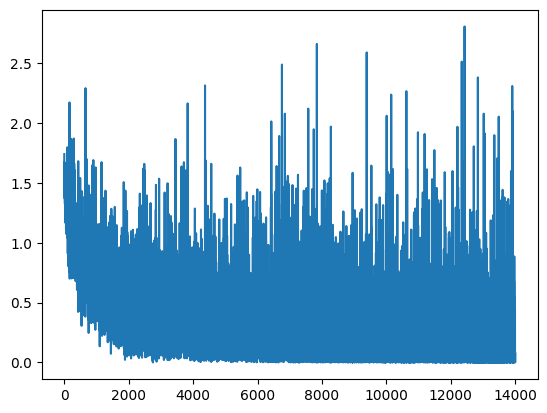

In [15]:
plt.plot(train_losses)

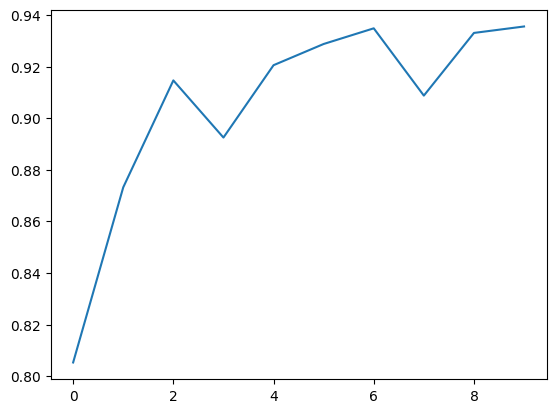

In [16]:
plt.plot(test_accuracy)

In [17]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [18]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 5239/5600 (0.9355)
{'acc_detail': tensor([0.9307, 0.9164, 0.9821, 0.9129], device='cuda:0'),
 'acc_unweighted': tensor(0.9355, device='cuda:0'),
 'acc_weighted': tensor(0.9355, device='cuda:0'),
 'f1s_detail': tensor([0.9208, 0.9396, 0.9493, 0.9322], device='cuda:0'),
 'f1s_unweighted': tensor(0.9355, device='cuda:0'),
 'f1s_weighted': tensor(0.9355, device='cuda:0'),
 'precision_detail': tensor([0.9112, 0.9639, 0.9185, 0.9523], device='cuda:0'),
 'recall_detail': tensor([0.9307, 0.9164, 0.9821, 0.9129], device='cuda:0'),
 'rocauc': tensor(0.9945, device='cuda:0'),
 'rocauc_detail': tensor([0.9911, 0.9956, 0.9974, 0.9939], device='cuda:0'),
 'uar': tensor(0.9355, device='cuda:0'),
 'wap': tensor(0.9365, device='cuda:0')}


tensor([[1303,   22,   21,   54],
        [  35, 1283,   76,    6],
        [   8,   13, 1375,    4],
        [  84,   13,   25, 1278]], device='cuda:0')

In [19]:
model_path = '../models_esd4/esd4_m13mfcc128_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50

best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_esd4/esd4_m13mfcc128_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [26]:
checkpoint_path = f'../models_esd4/esd4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

In [ ]:
filtviz.visualize_filters(filter_domain='freq')

In [ ]:
filtviz.visualize_one_window(n_out=10)

In [ ]:
filtviz.visualize_one_window(n_out=50)

In [ ]:
filtviz.visualize_window_params()

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
start_epoch = 151
n_epoch = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
start_epoch = 201
n_epoch = 300

optimizer = optim.RAdam(model.parameters(), lr=0.000001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)